<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#r-binning-for-$Y_{l=4}$-contaminated-potential-data" data-toc-modified-id="r-binning-for-$Y_{l=4}$-contaminated-potential-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>r-binning for $Y_{l=4}$ contaminated potential data</a></span><ul class="toc-item"><li><span><a href="#Subroutines-which-are-used-in-this-note" data-toc-modified-id="Subroutines-which-are-used-in-this-note-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Subroutines which are used in this note</a></span></li><li><span><a href="#Mock-up-wave-function-data" data-toc-modified-id="Mock-up-wave-function-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Mock up wave function data</a></span><ul class="toc-item"><li><span><a href="#Data-setup" data-toc-modified-id="Data-setup-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Data setup</a></span></li></ul></li><li><span><a href="#Spherical-harmonics" data-toc-modified-id="Spherical-harmonics-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Spherical harmonics</a></span></li><li><span><a href="#Wave-functions-with-spherical-harmonics" data-toc-modified-id="Wave-functions-with-spherical-harmonics-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Wave functions with spherical harmonics</a></span></li><li><span><a href="#The-potential-with-$Y_{l=4}$-contamination" data-toc-modified-id="The-potential-with-$Y_{l=4}$-contamination-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>The potential with $Y_{l=4}$ contamination</a></span></li><li><span><a href="#$A_1$-projection-for-the-wave-function" data-toc-modified-id="$A_1$-projection-for-the-wave-function-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>$A_1$ projection for the wave function</a></span></li></ul></li></ul></div>

In [1]:
###=== Import modules which are used in this note & global setup ===###

import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

import plotly.offline    as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected=True)

import sys, os
sys.path.append("/home/miyamoto/python_code-set/lib")
from misc_QM.special_functions   import sph_harm_xyz
from lattice.rotation_projection import rot_proj
from lattice.calc_laplacian      import lap

show_graph = False

# r-binning for $Y_{l=4}$ contaminated potential data

## Subroutines which are used in this note

In [2]:
###=== The function for making r-binning data ===###
# idata[0,:] = r-coordinate, idata[1,:] = value
# odata[0,:] = r-coordinate, odata[1,:] = value, odata[2,:] = xerr, odata[3,:] = yerr
def rbin(idata, nbin = 1):
    iNd = len(idata[0,:])
    o_r     = []
    odata   = []
    od_xerr = []
    od_yerr = []
    for bin_r in np.arange(0.0, np.max(idata[0,:]), nbin):
        tmpr = tmpr2 = tmpd = tmpd2 = Nbind = 0
        for ir in range(iNd):
            if (bin_r <= idata[0,ir] < bin_r+nbin):
                tmpr  += idata[0,ir]
                tmpr2 += idata[0,ir]**2
                tmpd  += idata[1,ir]
                tmpd2 += idata[1,ir]**2
                Nbind += 1
        if (Nbind != 0):
            o_r  .append(tmpr/float(Nbind))
            odata.append(tmpd/float(Nbind))
            if (Nbind == 1):
                od_xerr.append(0.0)
                od_yerr.append(0.0)
            else:
                od_xerr.append(np.sqrt(tmpr2-tmpr**2)/float(Nbind))
                od_yerr.append(np.sqrt(tmpr2-tmpr**2)/float(Nbind))
    return np.array((o_r,odata,od_xerr,od_yerr))

## Mock up wave function data

* 
<font size=3>
    I define the wave function by  
    <br>
    <font color=red>
        \begin{equation} \psi(r) = \exp\left[ -\frac{r^2}{60} \right]+3, \end{equation}
    </font>
    <br>
    where $r = \sqrt{x^2+y^2+z^2}$
</font>

<br>

* 
<font size=3>
    Then, potential is defined as  
    <br>
    <font color=red>
        \begin{equation} V(r) = \frac{\nabla^2 \psi(r)}{\psi(r)} \end{equation}
    </font>
</font>

### Data setup

* 
<font size=3>
    Lattice: $(L_x,L_y,L_z) = (96,96,96)$ with the <font color='red'>periodic boundary condition</font>
</font>

In [3]:
Ls  = 96

In [4]:
###=== Generate a mock up wave function on the 3D-lattice ===###

rng  = np.arange(Ls)
Lpbc = [(i if i < Ls//2 else i-Ls) for i in rng]
psi  = np.array([[[-np.exp(-(Lpbc[x]**2+Lpbc[y]**2+Lpbc[z]**2)/60.0) + 3.0 
                   for x in rng] for y in rng] for z in rng])
rcrd = np.array([[[np.sqrt(Lpbc[x]**2 + Lpbc[y]**2 + Lpbc[z]**2)
                   for x in rng] for y in rng] for z in rng])

In [5]:
###=== Generate a mock up potential on the 3D-lattice ===###

pot = lap(psi)/psi

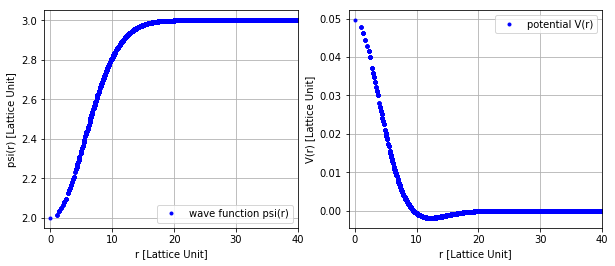

In [6]:
###=== 2-D plot for the psi(r) and V(r) ===###

if (show_graph or True):
    r_flt = rcrd.flatten()
    psi_r = psi .flatten()
    pot_r = pot .flatten()
    fig, axe = plt.subplots(ncols=2, figsize=(10,4), sharex=True)
    axe[0].plot(r_flt,psi_r,'b.', label='wave function psi(r)')
    axe[1].plot(r_flt,pot_r,'b.', label='potential V(r)')
    axe[0].set_xlim(-1,40)
    axe[0].legend(numpoints=1, loc='lower right')
    axe[1].legend(numpoints=1, loc='upper right')
    axe[0].set_ylabel('psi(r) [Lattice Unit]')
    axe[1].set_ylabel('V(r) [Lattice Unit]')
    for i in range(2):
        axe[i].grid(True)
        axe[i].set_xlabel('r [Lattice Unit]')

## Spherical harmonics
<br>
<font size=3>
\begin{equation} Y_0^0~~(r) = \frac{1}{2\sqrt{2\pi}} \end{equation}
<font color=red>  
\begin{equation} Y_4^0~~(r) =  \end{equation}  
\begin{equation} Y_4^{-4}(r) =  \end{equation}  
\begin{equation} Y_4^{+4}(r) =  \end{equation}
</font>

In [7]:
###=== Generate the spherical harmonicses (L = 0 and 4) on the 3D-lattice ===###

rng  = np.arange(Ls)
Y00  = np.array([[[sph_harm_xyz(0, 0, Lpbc[x],Lpbc[y],Lpbc[z]) for x in rng] for y in rng] for z in rng])
Y40  = np.array([[[sph_harm_xyz(4, 0, Lpbc[x],Lpbc[y],Lpbc[z]) for x in rng] for y in rng] for z in rng])
Y4m4 = np.array([[[sph_harm_xyz(4,-4, Lpbc[x],Lpbc[y],Lpbc[z]) for x in rng] for y in rng] for z in rng])
Y4p4 = np.array([[[sph_harm_xyz(4,+4, Lpbc[x],Lpbc[y],Lpbc[z]) for x in rng] for y in rng] for z in rng])

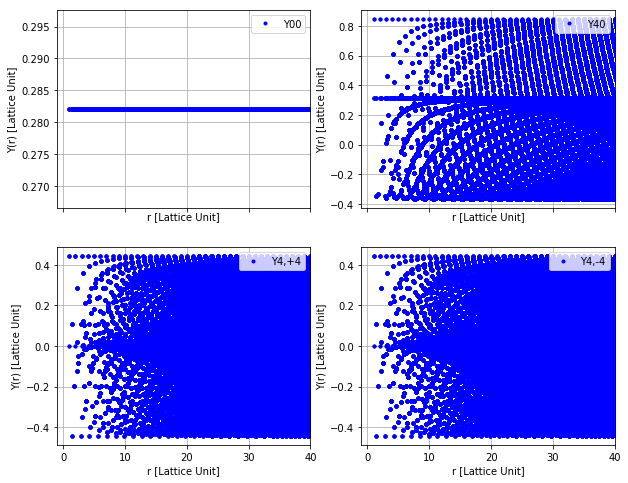

In [8]:
###=== 2-D plot for the Y_lm(r) ===###

if (show_graph or True):
    r_flt  = rcrd.flatten()
    Y00_r  = Y00 .flatten().real
    Y40_r  = Y40 .flatten().real
    Y4m4_r = Y4m4.flatten().real
    Y4p4_r = Y4p4.flatten().real
    fig, axe = plt.subplots(ncols=2, nrows=2, figsize=(10,8), sharex=True)
    axe[0,0].plot(r_flt,Y00_r ,'b.', label='Y00')
    axe[0,1].plot(r_flt,Y40_r ,'b.', label='Y40')
    axe[1,0].plot(r_flt,Y4m4_r,'b.', label='Y4,+4')
    axe[1,1].plot(r_flt,Y4p4_r,'b.', label='Y4,-4')
    axe[0,0].set_xlim(-1,40)
    for i in range(2):
        for j in range(2):
            axe[i,j].grid(True)
            axe[i,j].legend(numpoints=1, loc='upper right')
            axe[i,j].set_ylabel('Y(r) [Lattice Unit]')
            axe[i,j].set_xlabel('r [Lattice Unit]')

In [9]:
###=== 3-D plot for the spherical harmonicses (Y_40) ===###

if (show_graph):
    nsp = 6
    pd  = Y40.copy()
    pd[np.isnan(pd)] = 0.0
    rng = np.arange(0,Ls,nsp)
    p = [
        np.array([[[Lpbc[x] for x in rng] for y in rng] for z in rng]).flatten(),
        np.array([[[Lpbc[y] for x in rng] for y in rng] for z in rng]).flatten(),
        np.array([[[Lpbc[z] for x in rng] for y in rng] for z in rng]).flatten(),
        pd[::nsp,::nsp,::nsp].flatten().real
    ]
    offline.iplot(dict(data=[go.Scatter3d(x=p[0],y=p[1],z=p[2], mode='markers',
                                          marker=dict(color=p[3], 
                                                      size=(p[3]-np.min(p[3]))*20,
                                                      colorscale='Jet', 
                                                      opacity=0.4, 
                                                      showscale=True))],
                       layout=dict(margin=dict(l=0,r=0,b=0,t=0))))

## Wave functions with spherical harmonics
<br>
<font size=3>
\begin{equation} \psi_{0~~~~~~}(r) = Y_0^0 (r) ~ \psi(r) \end{equation}
<font color=red>  
\begin{equation} \psi_{4,0~~~}(r) = Y_0^0 (r) ~ \psi(r) + 0.01 ~ Y_4^0 ~~(r) ~ \psi(r) \end{equation}  
\begin{equation} \psi_{4,-4}(r) = Y_0^0 (r) ~ \psi(r) + 0.01 ~ Y_4^{-4} (r) ~ \psi(r) \end{equation}  
\begin{equation} \psi_{4,+4}(r) = Y_0^0 (r) ~ \psi(r) + 0.01 ~ Y_4^{+4} (r) ~ \psi(r) \end{equation}
</font>

In [10]:
###=== Generate wave functions with the spherical harmonicses (L = 0 and/or 4) on the 3D-lattice ===###

Ncontami = 0.01
psi_0    = Y00  * psi
psi_40   = Y00  * psi + Ncontami * Y40  * psi
psi_4m4  = Y00  * psi + Ncontami * Y4m4 * psi
psi_4p4  = Y00  * psi + Ncontami * Y4p4 * psi

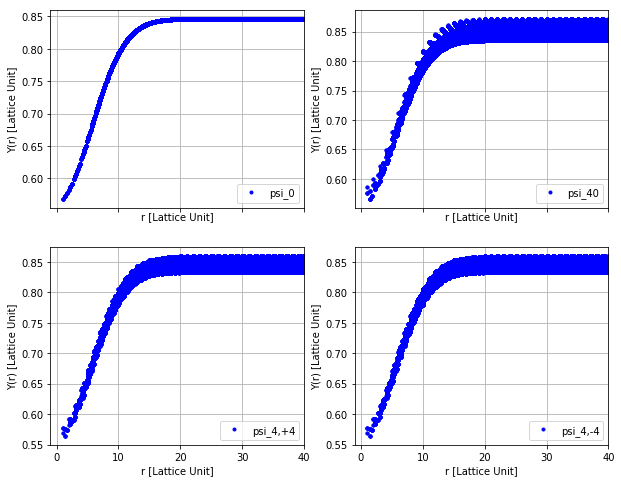

In [11]:
###=== 2-D plot for the wave functions with the spherical harmonicses  ===###

if (show_graph or True):
    r_flt     = rcrd   .flatten()
    psi_0_r   = psi_0  .flatten().real
    psi_40_r  = psi_40 .flatten().real
    psi_4m4_r = psi_4m4.flatten().real
    psi_4p4_r = psi_4p4.flatten().real
    fig, axe = plt.subplots(ncols=2, nrows=2, figsize=(10,8), sharex=True)
    axe[0,0].plot(r_flt,psi_0_r  ,'b.', label='psi_0')
    axe[0,1].plot(r_flt,psi_40_r ,'b.', label='psi_40')
    axe[1,0].plot(r_flt,psi_4m4_r,'b.', label='psi_4,+4')
    axe[1,1].plot(r_flt,psi_4p4_r,'b.', label='psi_4,-4')
    axe[0,0].set_xlim(-1,40)
    for i in range(2):
        for j in range(2):
            axe[i,j].grid(True)
            axe[i,j].legend(numpoints=1, loc='lower right')
            axe[i,j].set_ylabel('Y(r) [Lattice Unit]')
            axe[i,j].set_xlabel('r [Lattice Unit]')

## The potential with $Y_{l=4}$ contamination
<br>
<font size=3>
    The potentials are defined by  
    <br>
    \begin{equation} V_X = \frac{\nabla^2 \psi_X(r)}{\psi_X(r)} \end{equation}
    <br>
    where $X = 0~~\mathrm{or}~~40~~\mathrm{or}~~4,+4~~\mathrm{or}~~4,-4$
</font>

In [12]:
###=== Generate potentials with Y4 contamination on the 3D-lattice ===###

pot_0   = lap(psi_0  )/psi_0
pot_40  = lap(psi_40 )/psi_40
pot_4m4 = lap(psi_4m4)/psi_4m4
pot_4p4 = lap(psi_4p4)/psi_4p4

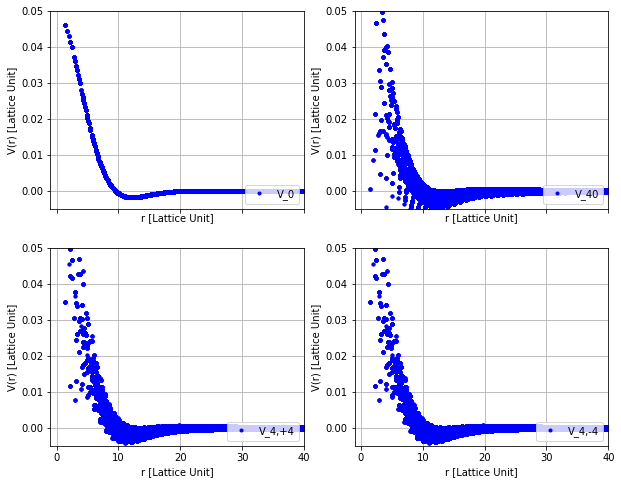

In [13]:
###=== 2-D plot for the potentials with Y4 contamination  ===###

if (show_graph or True):
    r_flt     = rcrd   .flatten()
    pot_0_r   = pot_0  .flatten().real
    pot_40_r  = pot_40 .flatten().real
    pot_4m4_r = pot_4m4.flatten().real
    pot_4p4_r = pot_4p4.flatten().real
    fig, axe = plt.subplots(ncols=2, nrows=2, figsize=(10,8), sharex=True)
    axe[0,0].plot(r_flt,pot_0_r  ,'b.', label='V_0')
    axe[0,1].plot(r_flt,pot_40_r ,'b.', label='V_40')
    axe[1,0].plot(r_flt,pot_4m4_r,'b.', label='V_4,+4')
    axe[1,1].plot(r_flt,pot_4p4_r,'b.', label='V_4,-4')
    axe[0,0].set_xlim(-1,40)
    for i in range(2):
        for j in range(2):
            axe[i,j].grid(True)
            axe[i,j].set_ylim(-0.005,0.05)
            axe[i,j].legend(numpoints=1, loc='lower right')
            axe[i,j].set_ylabel('V(r) [Lattice Unit]')
            axe[i,j].set_xlabel('r [Lattice Unit]')

## $A_1$ projection for the wave function

In [14]:
psi_0_A1   = rot_proj(psi_0  , a_state="A1")
psi_40_A1  = rot_proj(psi_40 , a_state="A1")
psi_4m4_A1 = rot_proj(psi_4m4, a_state="A1")
psi_4p4_A1 = rot_proj(psi_4p4, a_state="A1")

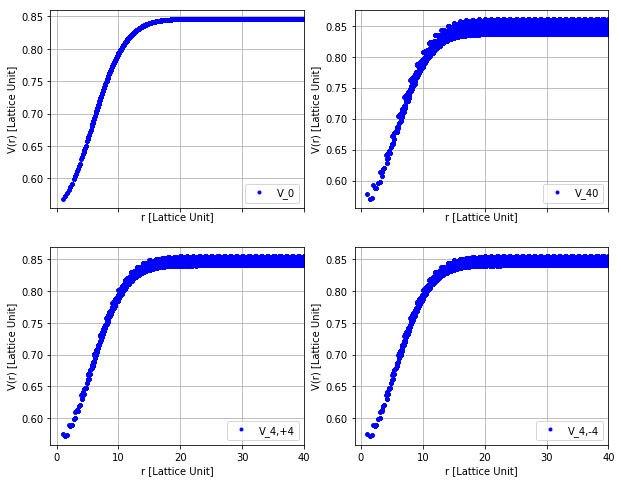

In [15]:
###=== 2-D plot for the A1 projected wave function  ===###

if (show_graph or True):
    r_flt     = rcrd   .flatten()
    psi_0_A1_r   = psi_0_A1  .flatten().real
    psi_40_A1_r  = psi_40_A1 .flatten().real
    psi_4m4_A1_r = psi_4m4_A1.flatten().real
    psi_4p4_A1_r = psi_4p4_A1.flatten().real
    fig, axe = plt.subplots(ncols=2, nrows=2, figsize=(10,8), sharex=True)
    axe[0,0].plot(r_flt,psi_0_A1_r  ,'b.', label='V_0')
    axe[0,1].plot(r_flt,psi_40_A1_r ,'b.', label='V_40')
    axe[1,0].plot(r_flt,psi_4m4_A1_r,'b.', label='V_4,+4')
    axe[1,1].plot(r_flt,psi_4p4_A1_r,'b.', label='V_4,-4')
    axe[0,0].set_xlim(-1,40)
    for i in range(2):
        for j in range(2):
            axe[i,j].grid(True)
            #axe[i,j].set_ylim(-0.005,0.05)
            axe[i,j].legend(numpoints=1, loc='lower right')
            axe[i,j].set_ylabel('V(r) [Lattice Unit]')
            axe[i,j].set_xlabel('r [Lattice Unit]')